<a href="https://colab.research.google.com/github/anmatrapazis/FashionMNIST-MLP-CNN/blob/main/FMNIST_MLP_Matrapazis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Libraries


In [ ]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
import gc
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras import layers


from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model # The class used to create a model
from keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation

## Load data

> as [tensorflow fashion_mnist](https://www.tensorflow.org/tutorials/keras/classification) shows

In [ ]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size = 0.2, random_state = 42)

In [ ]:
print('Fashion MNIST Dataset Shape:')
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val:  ', x_val.shape)
print('y_val:  ', y_val.shape)
print('x_test:  ', x_test.shape)
print('y_test:  ', y_test.shape)


Fashion MNIST Dataset Shape:
x_train:  (48000, 28, 28)
y_train:  (48000,)
x_val:   (12000, 28, 28)
y_val:   (12000,)
x_test:   (10000, 28, 28)
y_test:   (10000,)


In [ ]:
labels = {0:"T-shirt/top",
          1:"Trouser",
          2:"Pullover",
          3:"Dress",
          4:"Coat",
          5:"Sandal",
          6:"Shirt",
          7:"Sneaker",
          8:"Bag",
          9:"Ankle boot"
}

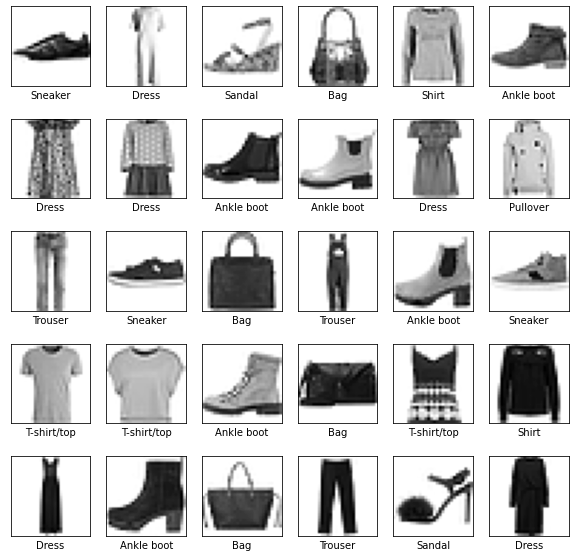

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

## Preprocess for Sequential MLP

In [ ]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Clean model

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    #plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

# Sequential MLP

1. How many hidden layers?
2. Ho many numbers of neurons?
3. Learning Rate?

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
#from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

#init model

from tensorflow.keras.layers import Input


def build_model(hp):
  model = keras.Sequential()
  model.add(Flatten(input_shape = (28,28))) #flattening the image
  model.add(Dropout(hp.Float('dropout', min_value = 0, max_value = 0.3, step=0.1)))
  for i in range(hp.Int('num_layers',1,4)):
#    model.add(Dense(units = hp.Int('hidden_units '+str(i),
#                              min_value = 32,
#                              max_value = 512,
#                              step = 32), 
#                    activation='relu'))
    
    model.add(Dense(units = hp.Choice('hidden_units '+str(i), [512,256,128,64,35]), 
                    activation='relu'))

    model.add(Dropout(hp.Float('dropout_hidden '+str(i),
                               min_value = 0,
                               max_value = 0.4,
                               step=0.1)))
  model.add(Dense(10, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])

  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  

  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 102kB 5.8MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=18a208ec68ca6188f408556a2ab44638e999b08c055f4972a163e32434966aaa
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
tuner = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 5,
    executions_per_trial=2,
    directory = 'my_dir2',
    project_name = 'helloworld2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience = 5)
with tf.device('/device:GPU:0'):
  tuner.search(x_train, y_train,
              epochs=50,
              validation_data=(x_val, y_val), 
              callbacks=[es])


Trial 5 Complete [00h 01m 26s]
val_loss: 0.42322807013988495

Best val_loss So Far: 0.30998192727565765
Total elapsed time: 00h 16m 50s
INFO:tensorflow:Oracle triggered exit


> In general, I noticed during the tuning process that a model that goes from general to specific (more hidden units at the first hidden layers, less hidden units at the last hidden layers) has better performance that the models that follows specific to general pattern.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

Results summary
Results in my_dir2/helloworld2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout: 0.1
num_layers: 3
hidden_units 0: 512
dropout_hidden 0: 0.1
learning_rate: 0.001
hidden_units 1: 128
dropout_hidden 1: 0.1
hidden_units 2: 512
dropout_hidden 2: 0.0
hidden_units 3: 35
dropout_hidden 3: 0.1
Score: 0.30998192727565765
Trial summary
Hyperparameters:
dropout: 0.1
num_layers: 4
hidden_units 0: 256
dropout_hidden 0: 0.2
learning_rate: 0.001
hidden_units 1: 128
dropout_hidden 1: 0.2
hidden_units 2: 128
dropout_hidden 2: 0.30000000000000004
hidden_units 3: 35
dropout_hidden 3: 0.1
Score: 0.3192302882671356
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
num_layers: 2
hidden_units 0: 256
dropout_hidden 0: 0.4
learning_rate: 0.001
hidden_units 1: 512
dropout_hidden 1: 0.2
hidden_units 2: 64
dropout_hidden 2: 0.30000000000000004
hidden_units 3: 256
dropout_hidden 3: 0.0
Score: 0.3250046670436859
Trial summary
Hyperpa

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        x_train, 
        y_train,
        validation_data=(x_val, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/250
6/6 [==============================] - 1s 63ms/step - loss: 1.7761 - accuracy: 0.4491 - val_loss: 1.0072 - val_accuracy: 0.6688
Epoch 2/250
6/6 [==============================] - 0s 32ms/step - loss: 0.9211 - accuracy: 0.6722 - val_loss: 0.7754 - val_accuracy: 0.7068
Epoch 3/250
6/6 [==============================] - 0s 30ms/step - loss: 0.7579 - accuracy: 0.7256 - val_loss: 0.6560 - val_accuracy: 0.7616
Epoch 4/250
6/6 [==============================] - 0s 30ms/step - loss: 0.6579 - accuracy: 0.7601 - val_loss: 0.5708 - val_accuracy: 0.7986
Epoch 5/250
6/6 [==============================] - 0s 31ms/step - loss: 0.5945 - accuracy: 0.7822 - val_loss: 0.5309 - val_accuracy: 0.8117
Epoch 6/250
6/6 [==============================] - 0s 27ms/step - loss: 0.5505 - accuracy: 0.8028 - val_loss: 0.5012 - val_accuracy: 0.8195
Epoch 7/250
6/6 [==============================] - 0s 27ms/step - loss: 0.5213 - accuracy: 0.8146 - val_loss: 0.4780 - val_accuracy: 0.8300
Epoch 8/250
6/6 [===

### curves

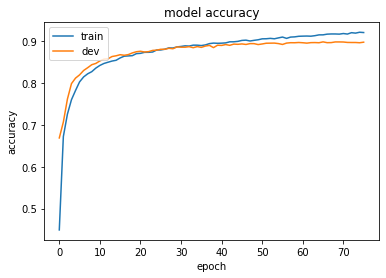

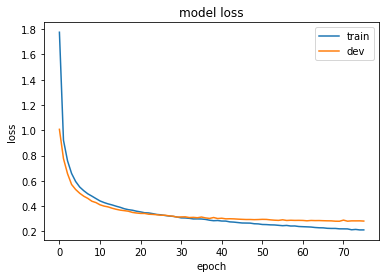

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(x_train))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(x_val))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')


#MLP on test set
test_pred = np.round(model.predict(x_test))
print('Test Set:')
print(classification_report(y_test, test_pred))

Training Set:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4798
           1       1.00      0.99      1.00      4781
           2       0.90      0.87      0.89      4795
           3       0.97      0.92      0.94      4816
           4       0.88      0.88      0.88      4798
           5       1.00      1.00      1.00      4789
           6       0.90      0.77      0.83      4782
           7       0.98      0.99      0.98      4841
           8       1.00      1.00      1.00      4803
           9       0.99      0.98      0.99      4797

   micro avg       0.95      0.93      0.94     48000
   macro avg       0.95      0.93      0.94     48000
weighted avg       0.95      0.93      0.94     48000
 samples avg       0.93      0.93      0.93     48000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1202
           1       1.00      0.98      0.99      1219
           2       0.84      0.82      0.83      1205
           3       0.93      0.87      0.90      1184
           4       0.83      0.83      0.83      1202
           5       0.98      0.96      0.97      1211
           6       0.82      0.67      0.74      1218
           7       0.95      0.95      0.95      1159
           8       0.98      0.96      0.97      1197
           9       0.95      0.96      0.96      1203

   micro avg       0.91      0.89      0.90     12000
   macro avg       0.91      0.89      0.90     12000
weighted avg       0.91      0.89      0.90     12000
 samples avg       0.89      0.89      0.89     12000

Test Set:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1000
           1       1.00      0.97      0.98      100

# CNN

In [ ]:
#from tensorflow.keras.layers import Conv2D,Activation, MaxPool2D


In [ ]:
x_train_cnn = x_train.reshape(len(x_train),28,28,1)

In [ ]:
train_images = x_train.reshape(len(x_train), 28, 28, 1)
val_images = x_val.reshape(len(x_val), 28, 28, 1)
test_images = x_test.reshape(len(x_test), 28, 28, 1)

# Να βάλω dropouts

In [ ]:
def build_model_cnn(hp):
  model = keras.Sequential()

  model.add(Conv2D(filters = hp.Int('conv_1_filter',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
           
#      filters=hp.int("input_units",min_value=32,max_value=256,step=32),(3,3) ,input_shape=train_images[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  for i in range(hp.Int('hidden_layers',1,4)):
    model.add(Conv2D(filters = hp.Int('conv_1_filter '+str(i),min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel '+str(i),values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
    model.add(Activation('relu'))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])
  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

In [ ]:
tuner_cnn = RandomSearch(
    build_model_cnn,
    objective = 'val_loss',
    max_trials = 5,
    executions_per_trial = 2,
    directory = 'my_dir3',
    project_name = 'helloworld3')

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience = 5)
with tf.device('/device:GPU:0'):
  tuner_cnn.search(train_images, y_train,
              epochs=50,
              validation_data=(val_images, y_val), 
              callbacks=[es])

Trial 5 Complete [00h 04m 50s]
val_loss: 1.3656060099601746

Best val_loss So Far: 0.2502725273370743
Total elapsed time: 00h 20m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps_cnn=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
tuner_cnn.results_summary

<bound method BaseTuner.results_summary of <keras_tuner.tuners.randomsearch.RandomSearch object at 0x7fbbfd808610>>

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_cnn.hypermodel.build(best_hps)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_images, 
        y_train,
        validation_data=(val_images, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/250
6/6 [==============================] - 4s 401ms/step - loss: 2.1324 - accuracy: 0.3621 - val_loss: 1.8099 - val_accuracy: 0.4871
Epoch 2/250
6/6 [==============================] - 1s 127ms/step - loss: 1.5077 - accuracy: 0.6005 - val_loss: 1.1202 - val_accuracy: 0.6752
Epoch 3/250
6/6 [==============================] - 1s 128ms/step - loss: 0.9692 - accuracy: 0.6898 - val_loss: 0.8338 - val_accuracy: 0.7157
Epoch 4/250
6/6 [==============================] - 1s 127ms/step - loss: 0.7817 - accuracy: 0.7293 - val_loss: 0.7357 - val_accuracy: 0.7442
Epoch 5/250
6/6 [==============================] - 1s 127ms/step - loss: 0.7010 - accuracy: 0.7534 - val_loss: 0.6702 - val_accuracy: 0.7630
Epoch 6/250
6/6 [==============================] - 1s 127ms/step - loss: 0.6456 - accuracy: 0.7659 - val_loss: 0.6182 - val_accuracy: 0.7758
Epoch 7/250
6/6 [==============================] - 1s 126ms/step - loss: 0.6027 - accuracy: 0.7803 - val_loss: 0.5833 - val_accuracy: 0.7902
Epoch 8/250
6

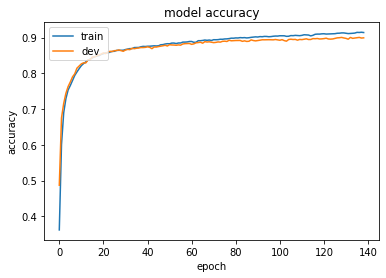

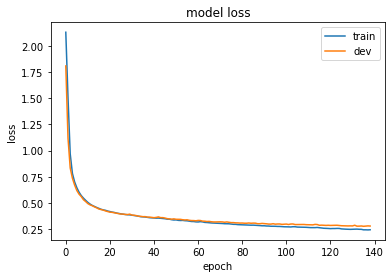

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(train_images))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(val_images))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')

#MLP on test set
test_pred = np.round(model.predict(test_images))
print('Test Set:')
print(classification_report(y_test, test_pred))

Training Set:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4798
           1       1.00      0.98      0.99      4781
           2       0.91      0.79      0.84      4795
           3       0.93      0.92      0.92      4816
           4       0.87      0.85      0.86      4798
           5       0.99      0.98      0.99      4789
           6       0.75      0.75      0.75      4782
           7       0.96      0.97      0.97      4841
           8       0.99      0.98      0.98      4803
           9       0.98      0.97      0.97      4797

   micro avg       0.93      0.90      0.91     48000
   macro avg       0.93      0.90      0.91     48000
weighted avg       0.93      0.90      0.91     48000
 samples avg       0.90      0.90      0.90     48000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1202
           1       1.00      0.97      0.98      1219
           2       0.90      0.78      0.83      1205
           3       0.89      0.91      0.90      1184
           4       0.84      0.82      0.83      1202
           5       0.97      0.98      0.97      1211
           6       0.74      0.73      0.74      1218
           7       0.95      0.96      0.96      1159
           8       0.98      0.96      0.97      1197
           9       0.97      0.96      0.96      1203

   micro avg       0.91      0.89      0.90     12000
   macro avg       0.91      0.89      0.90     12000
weighted avg       0.91      0.89      0.90     12000
 samples avg       0.89      0.89      0.89     12000

Test Set:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1000
           1       0.99      0.97      0.98      100

# Functional

In [ ]:
optimizer = SGD(lr=0.01, momentum= 0.9, nesterov = True)
#optimizer = Adam(lr=0.01)

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)

epochs = 100
model.compile(loss = 'sparse_categorical_crossentropy', #Computes the crossentropy loss between the labels and predictions.
              optimizer = optimizer,
              metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=1024, epochs = epochs, validation_split=0.2, callbacks=[es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


InvalidArgumentError: ignored

#### SGD

Train Loss     : 0.26888
Validation Loss: 0.29593
---
Train Accuracy     : 0.89783
Validation Accuracy: 0.89425



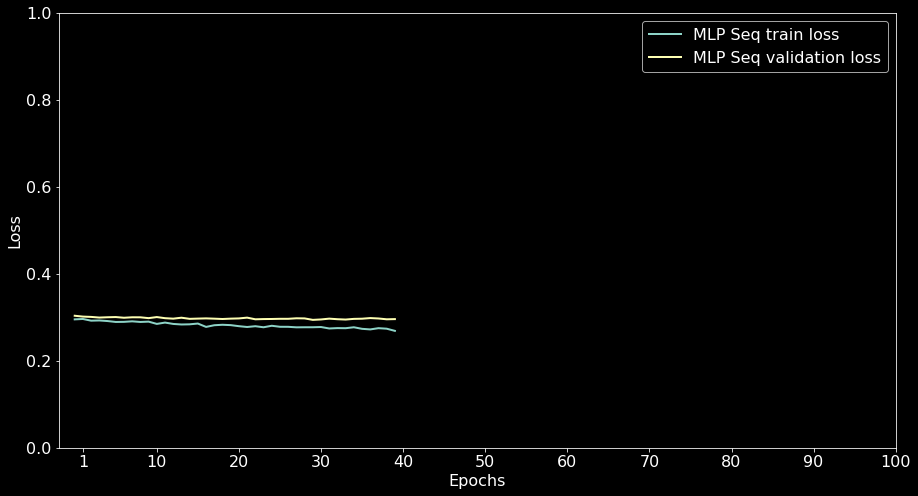

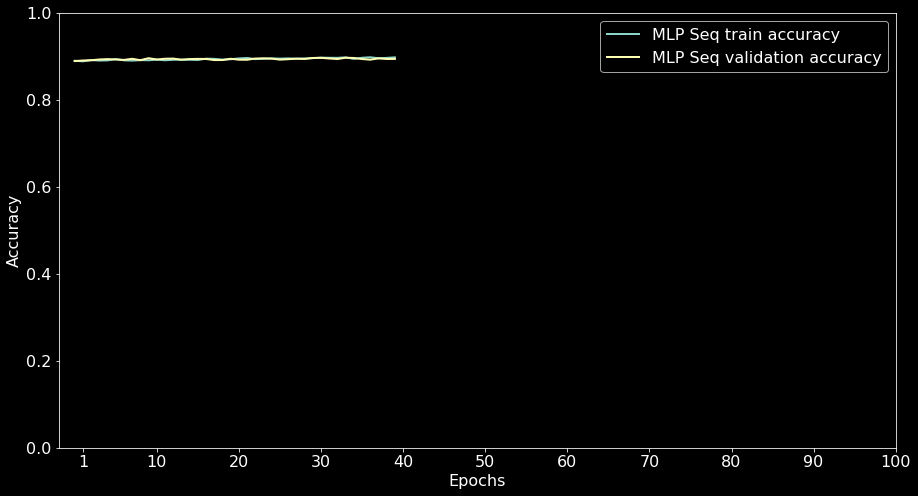

In [ ]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
#print("Test Loss      : {0:.5f}".format(history[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
#print("Test Accuracy      : {0:.5f}".format(history[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='accuracy')

#### ADAM

Train Loss     : 0.30944
Validation Loss: 0.30758
---
Train Accuracy     : 0.88538
Validation Accuracy: 0.88950



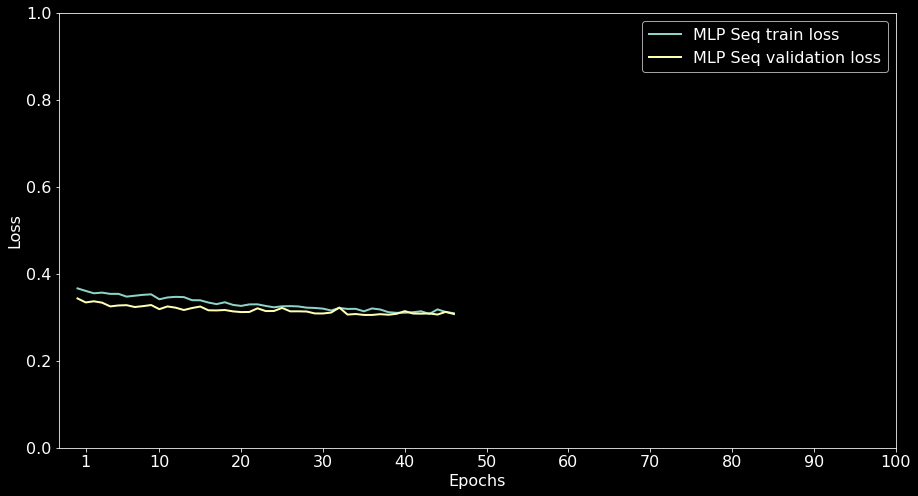

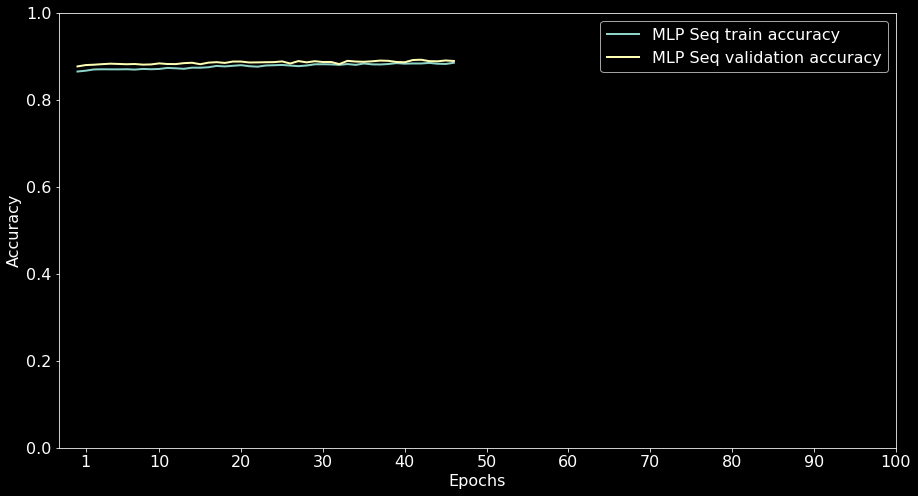

In [ ]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
#print("Test Loss      : {0:.5f}".format(history[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
#print("Test Accuracy      : {0:.5f}".format(history[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP Seq': history}, epochs=epochs, metric='accuracy')

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
x_ticks = np.arange(0, no_epochs + 1, 5)
x_ticks [0] += 1
plt.xticks(x_ticks)
plt.ylim((0, 1))
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title("optimizer: ADAM with momentum and Nesterov momentum-early stopping")
plt.legend()
plt.show()

## Preprocess for Functional

In [ ]:
batch_size = 128
classes = 10
epochs = 100
# Lets flatten the shapes
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]) 
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #Standardization of the pixels (max = 255)
x_test /= 255 #Standardization
y_train = to_categorical(y_train,classes) #autocreate a category vector
y_test = to_categorical(y_test,classes) #autocreate a category vector

## Testig some Functional MLPs
Trials based on class lab

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [ ]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    units = 256
    for i in range(hidden_layers):
        x = Dense(
            units=units/(i+1),
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### SGD

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=lr_model_sgd)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.4584 - accuracy: 0.8397


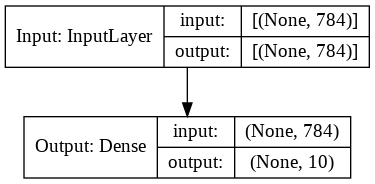

In [ ]:
tf.keras.utils.plot_model(lr_model_sgd, show_shapes=True)

Train Loss     : 0.41834
Validation Loss: 0.42424
Test Loss      : 0.45842
---
Train Accuracy     : 0.85804
Validation Accuracy: 0.85467
Test Accuracy      : 0.83970



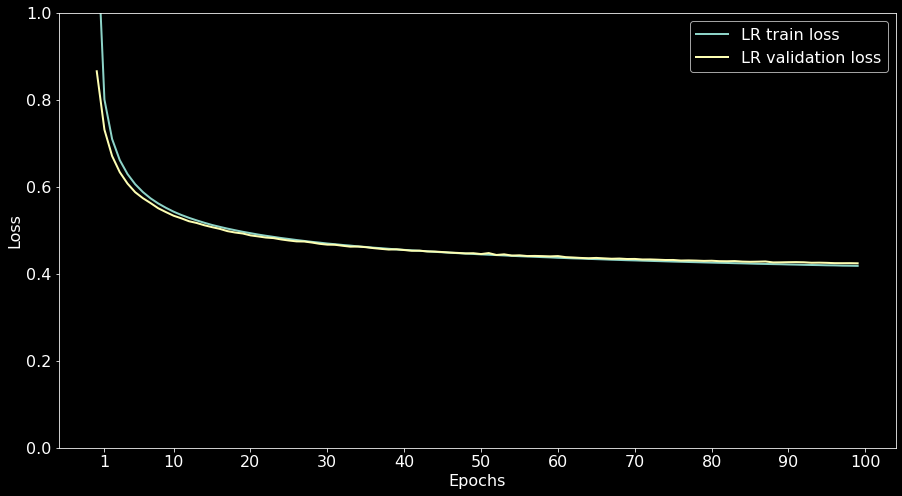

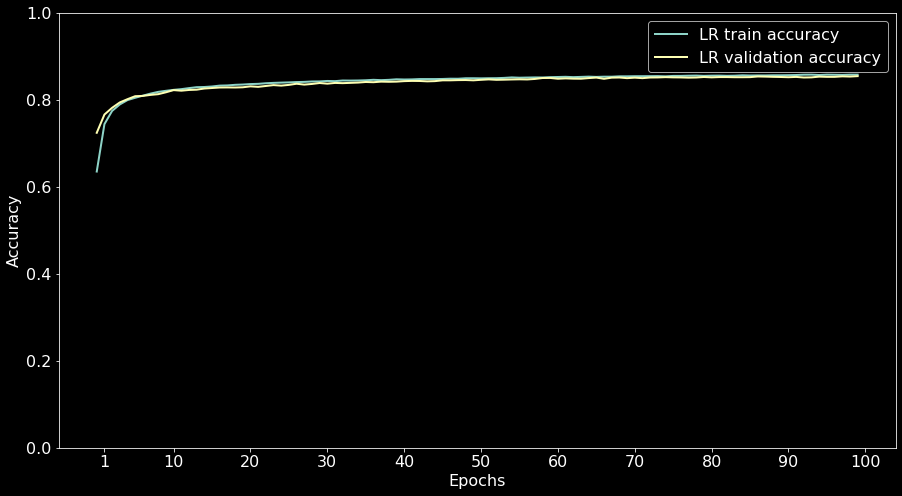

In [ ]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp_model_sgd)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.3599 - accuracy: 0.8719


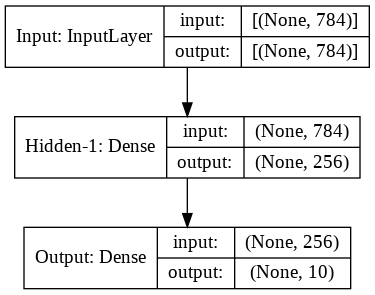

In [ ]:
tf.keras.utils.plot_model(mlp_model_sgd, show_shapes=True)

Train Loss     : 0.28756
Validation Loss: 0.33748
Test Loss      : 0.35988
---
Train Accuracy     : 0.89996
Validation Accuracy: 0.87783
Test Accuracy      : 0.87190



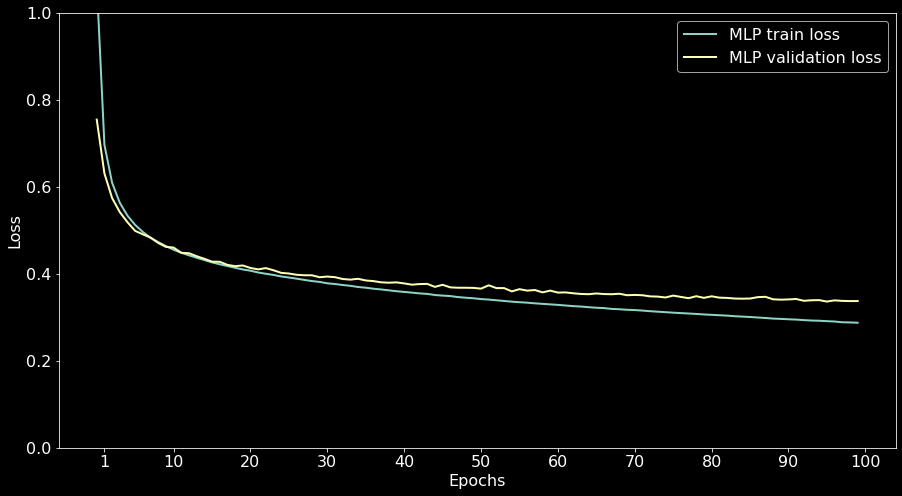

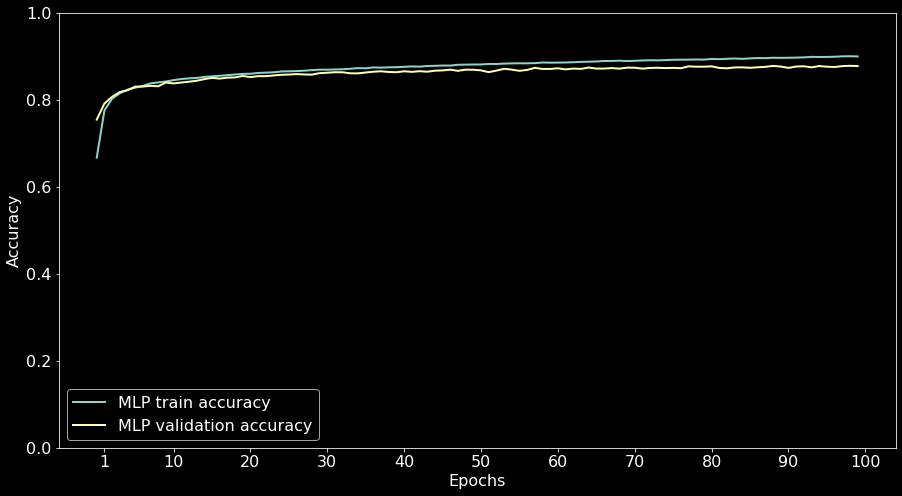

In [ ]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp2_model_sgd, mlp2_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp2_eval_sgd = mlp2_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp2_model_sgd)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Hidden-2 (Dense)             (None, 128)               32896     
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.3348 - accuracy: 0.8801


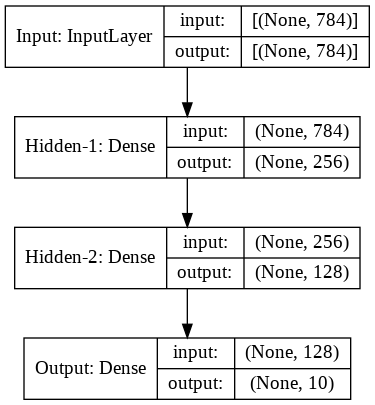

In [ ]:
tf.keras.utils.plot_model(mlp2_model_sgd, show_shapes=True)


Train Loss     : 0.22232
Validation Loss: 0.31443
Test Loss      : 0.33483
---
Train Accuracy     : 0.92165
Validation Accuracy: 0.88550
Test Accuracy      : 0.88010



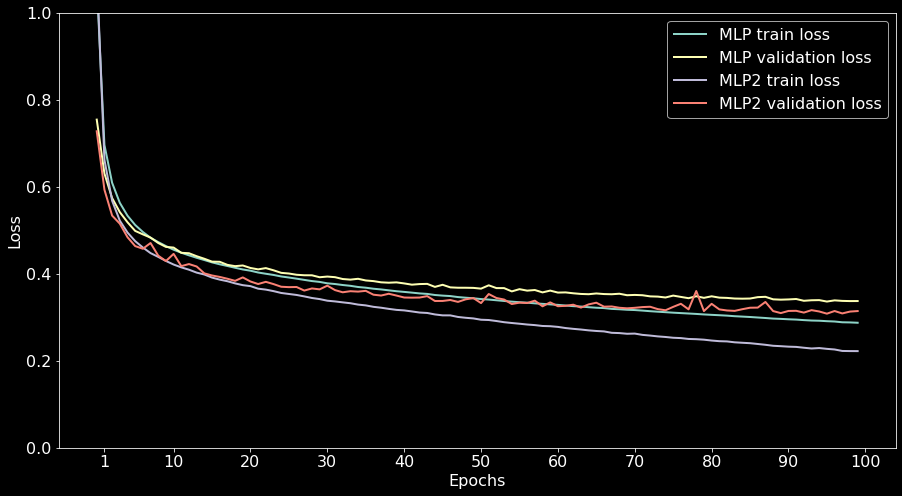

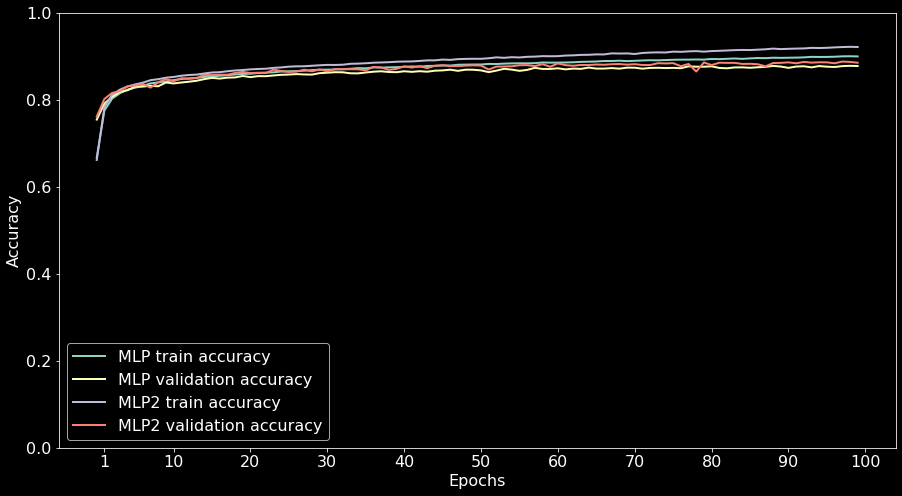

In [ ]:
print("Train Loss     : {0:.5f}".format(mlp2_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp2_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp2_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp2_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp2_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp2_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_sgd,'MLP2': mlp2_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_sgd, 'MLP2': mlp2_hs_sgd}, epochs=epochs, metric='accuracy')

In [ ]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp3_model_sgd, mlp3_hs_sgd = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp3_eval_sgd = mlp3_model_sgd.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp3_model_sgd)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Hidden-2 (Dense)             (None, 128)               32896     
_________________________________________________________________
Hidden-3 (Dense)             (None, 85)                10965     
_________________________________________________________________
Output (Dense)               (None, 10)                860       
Total params: 245,681
Trainable params: 245,681
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.3468 - accuracy: 0

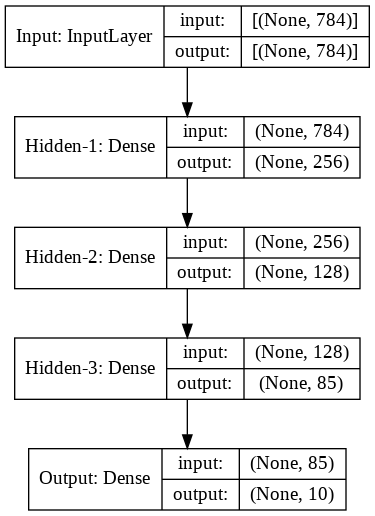

In [ ]:
tf.keras.utils.plot_model(mlp3_model_sgd, show_shapes=True)

Train Loss     : 0.17881
Validation Loss: 0.33354
Test Loss      : 0.35988
---
Train Accuracy     : 0.93628
Validation Accuracy: 0.88583
Test Accuracy      : 0.87190



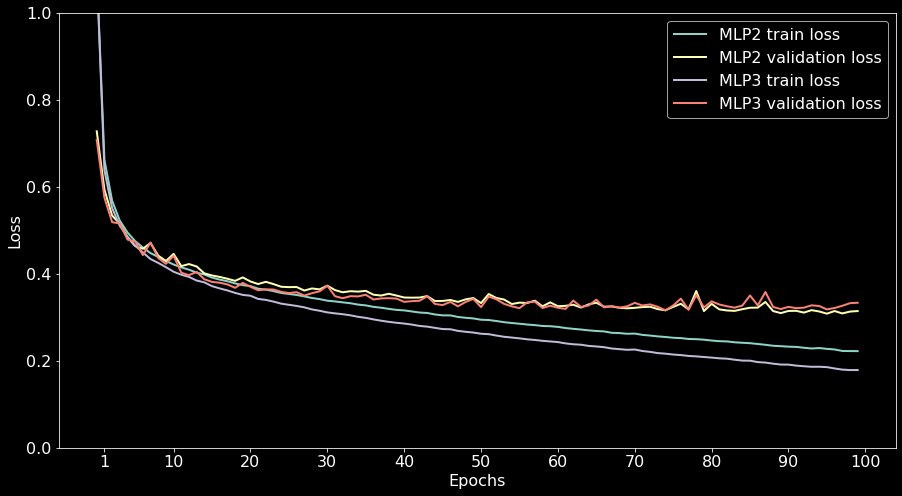

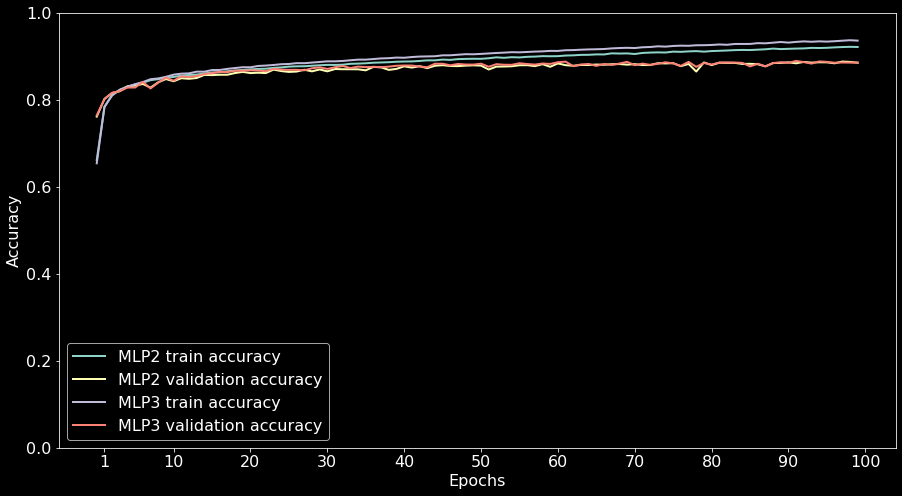

In [ ]:
print("Train Loss     : {0:.5f}".format(mlp3_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp3_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp3_hs_sgd.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp3_hs_sgd.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP2': mlp2_hs_sgd,'MLP3': mlp3_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'MLP2': mlp2_hs_sgd,'MLP3': mlp3_hs_sgd}, epochs=epochs, metric='accuracy')

### ADAM


In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.6781 - accuracy: 0.8910


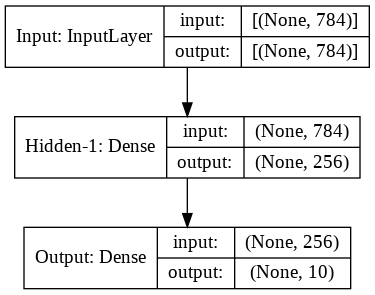

In [ ]:
tf.keras.utils.plot_model(mlp_model_adam, show_shapes=True)


In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp2_model_adam, mlp2_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp2_eval_adam = mlp2_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp2_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Hidden-2 (Dense)             (None, 128)               32896     
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.8882 - accuracy: 0.8880


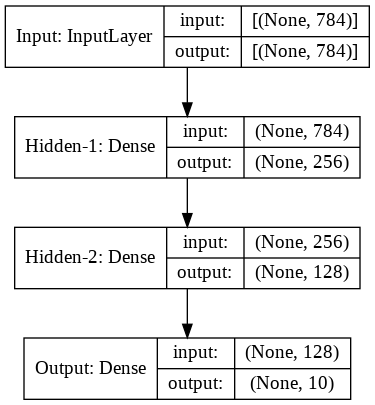

In [ ]:
tf.keras.utils.plot_model(mlp2_model_adam, show_shapes=True)

In [ ]:
# Using Adam
optimizer = Adam()

# MLP
mlp3_model_adam, mlp3_hs_adam = train_model(
    train_data=x_train,
    train_labels=y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp3_eval_adam = mlp3_model_adam.evaluate(x_test, y_test, verbose=1)
clean_up(model=mlp3_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Hidden-2 (Dense)             (None, 128)               32896     
_________________________________________________________________
Hidden-3 (Dense)             (None, 85)                10965     
_________________________________________________________________
Output (Dense)               (None, 10)                860       
Total params: 245,681
Trainable params: 245,681
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.8511 - accuracy: 0

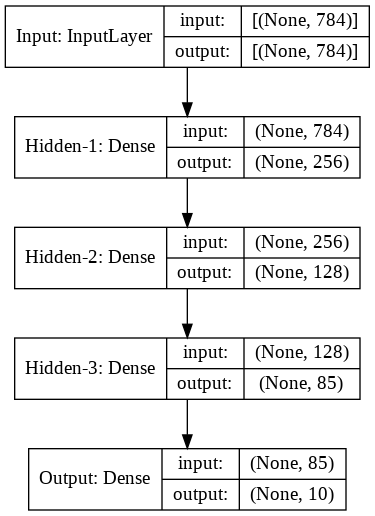

In [ ]:
tf.keras.utils.plot_model(mlp3_model_adam, show_shapes=True)


========== MLP ==========
Train Loss     : 0.03044
Validation Loss: 0.65184
Test Loss      : 0.67807
---
Train Accuracy     : 0.98961
Validation Accuracy: 0.89700
Test Accuracy      : 0.89100
========== MLP2 ==========
Train Loss     : 0.03616
Validation Loss: 0.88700
Test Loss      : 0.88821
---
Train Accuracy     : 0.98731
Validation Accuracy: 0.88600
Test Accuracy      : 0.88800
========== MLP3 ==========
Train Loss     : 0.03267
Validation Loss: 0.82121
Test Loss      : 0.85108
---
Train Accuracy     : 0.98824
Validation Accuracy: 0.89017
Test Accuracy      : 0.89230



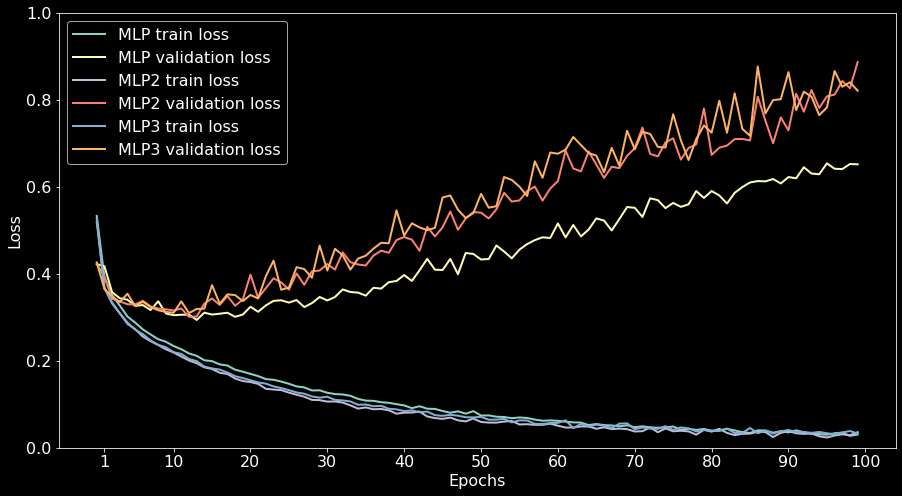

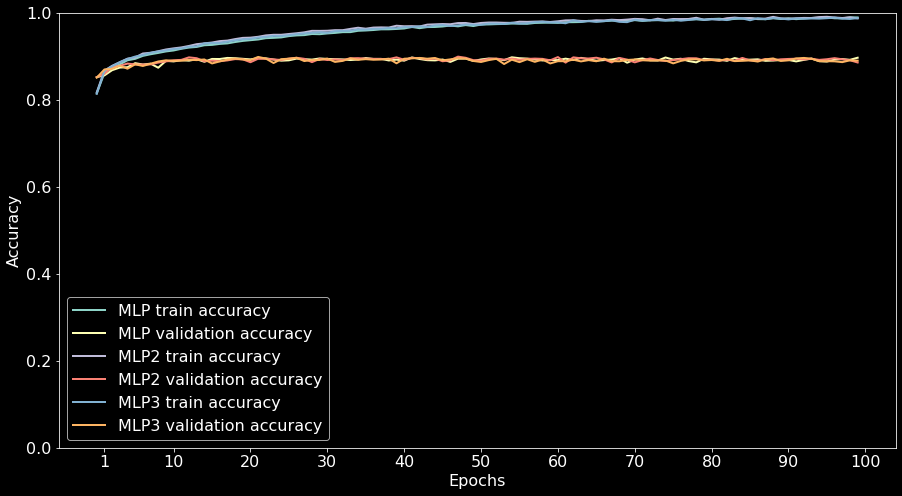

In [ ]:
print("========== MLP ==========")
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))

print("========== MLP2 ==========")

print("Train Loss     : {0:.5f}".format(mlp2_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp2_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp2_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp2_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp2_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp2_eval_adam[1]))

print("========== MLP3 ==========")

print("Train Loss     : {0:.5f}".format(mlp3_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp3_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp3_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp3_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp3_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp3_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'MLP': mlp_hs_adam, 'MLP2': mlp2_hs_adam, 'MLP3': mlp3_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': mlp_hs_adam, 'MLP2': mlp2_hs_adam, 'MLP3': mlp3_hs_adam}, epochs=epochs, metric='accuracy')

In [ ]:
mlp2_hs_sgd